# Zápočtová práce: Matematický software


## Úloha 1: Programová implementace SIR modelu
Implementujte SIR model pro 5 nemocí s různými reprodukčními čísly. Vizualizujte průběh a odpovězte:
1. Kdy nastává vrchol epidemie?
2. Jak dlouho epidemie trvá?
3. Kolik jedinců onemocní a kolik zůstane zdravých?

In [26]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import ipywidgets as widgets


In [35]:
def run_sir(R0, gamma, S0=0.99, I0=0.01, R0_init=0, days=175):
    # R0: reprodukční číslo (průměrný počet nových infekcí na 1 infikovaného)
    # gamma: míra rekonvalescence (1/počet dnů infekce)
    # S0, I0, R0_init: počáteční podíly Susceptible, Infected, Recovered
    beta = R0 * gamma           # infekčnost β - parametr šíření viru, počítán z reprodukčního čísla a parametru uzdravování
    def sir(t, y):
        S, I, R = y
        # dS/dt = –β·S·I
        dS = -beta * S * I
        # dI/dt = β·S·I – γ·I
        dI = beta * S * I - gamma * I
        # dR/dt = γ·I
        dR = gamma * I
        return [dS, dI, dR]
    sol = solve_ivp(sir, [0, days], [S0, I0, R0_init], dense_output=True)
    
    # vzorkujeme rovnoměrně po dnech pro hladké vykreslení
    t = np.linspace(0, days, days)
    S, I, R = sol.sol(t)
    return t, S, I, R


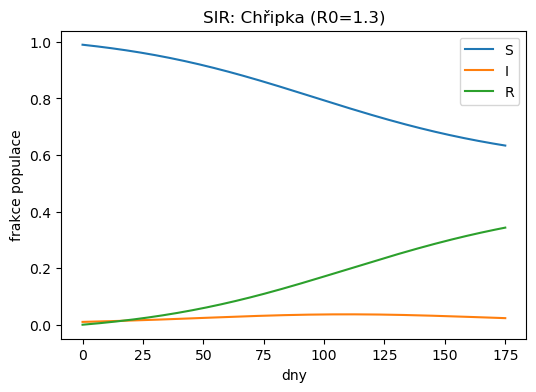

Chřipka: vrchol = den 109.6, trvání ≈ 175.0 dnů, onemocnělo 34.3%, zdravých 63.3%
/////////////////////////////////////////////////////////////////////////////////////////////


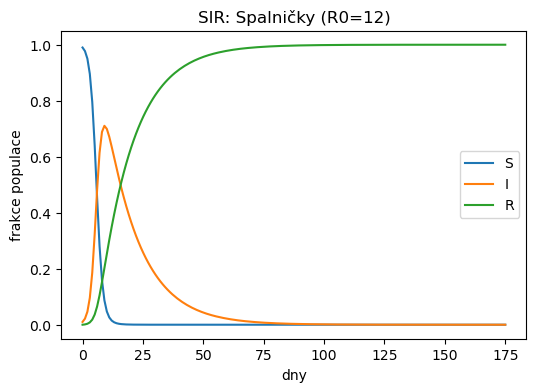

Spalničky: vrchol = den 9.1, trvání ≈ 102.6 dnů, onemocnělo 100.0%, zdravých 0.0%
/////////////////////////////////////////////////////////////////////////////////////////////


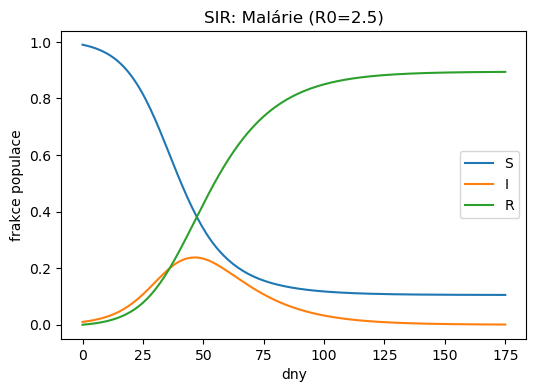

Malárie: vrchol = den 46.3, trvání ≈ 165.9 dnů, onemocnělo 89.4%, zdravých 10.5%
/////////////////////////////////////////////////////////////////////////////////////////////


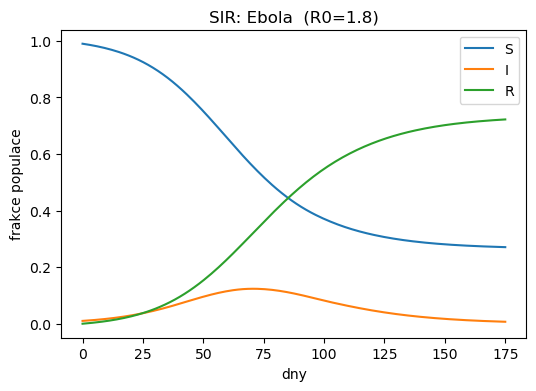

Ebola : vrchol = den 70.4, trvání ≈ 175.0 dnů, onemocnělo 72.2%, zdravých 27.1%
/////////////////////////////////////////////////////////////////////////////////////////////


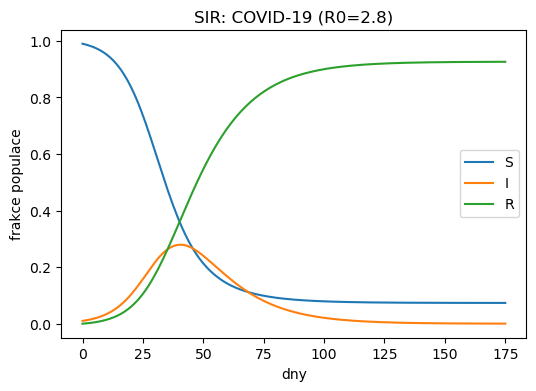

COVID-19: vrchol = den 40.2, trvání ≈ 153.9 dnů, onemocnělo 92.6%, zdravých 7.4%
/////////////////////////////////////////////////////////////////////////////////////////////


In [36]:
nemoce = {
    'Chřipka': 1.3,
    'Spalničky': 12,
    'Malárie': 2.5,
    'Ebola ': 1.8,
    'COVID-19': 2.8 # medián odhadovaných hodnot od 1.1.2020 do 7.2.2020, zdroj: https://pmc.ncbi.nlm.nih.gov/articles/PMC7751056/
}
gamma = 1/14  # rekonvalescence za 14 dnů

for jmeno, R0 in nemoce.items():
    # Spustíme simulaci SIR
    t, S, I, R = run_sir(R0, gamma)

    # Den s maximálním počtem nakažených
    vrchol_infekce = t[np.argmax(I)]

    # Definujeme práh pro "konec epidemie"
    prah = 1e-3
    # Najdeme všechny indexy, kde je podíl nakažených > práh
    idx = np.where(I > prah)[0]
    # Pokud jich je, vezmeme poslední den, jinak 0
    duration = t[idx[-1]] if idx.size else 0.0

    # Na konci simulace:
    celkem_nakazeni = R[-1]   # podíl, který už prošel infekcí
    zdravi = S[-1]          # podíl, který zůstal zdravý

    # …vykreslení a tisk výsledků…
    plt.figure(figsize=(6,4))
    plt.plot(t, S, label='S')
    plt.plot(t, I, label='I')
    plt.plot(t, R, label='R')
    plt.title(f'SIR: {jmeno} (R0={R0})')
    plt.xlabel('dny')
    plt.ylabel('frakce populace')
    plt.legend()
    plt.show()
    print(f"{jmeno}: vrchol = den {vrchol_infekce:.1f}, trvání ≈ {duration:.1f} dnů, onemocnělo {celkem_nakazeni*100:.1f}%, zdravých {zdravi*100:.1f}%")
    print("/////////////////////////////////////////////////////////////////////////////////////////////")


## Úloha 2: Úprava ekologického modelu Lotka-Volterra
1. Základní model kořist–predátor.
2. Přidejte třetí druh do systému a zobrazte jeho vliv.


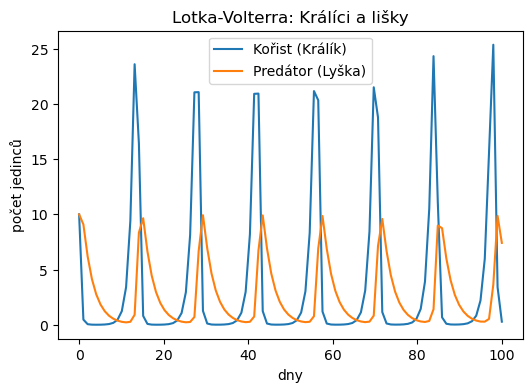

In [29]:
def run_lv(params, y0, days=100):
    # params = (a, b, c, d):
    #   a: reprodukce kořisti
    #   b: rychlost predace (jak efektivně predátor loví kořist)
    #   c: úmrtnost predátora
    #   d: reprodukce predátora v závislosti na úlovku
    a, b, c, d = params

    def lv(t, y):
        x, y1 = y           # x = počet kořisti, y1 = počet predátorů
        dx = a*x - b*x*y1   # růst kořisti minus ztráty predací
        dy = -c*y1 + d*x*y1 # úhyn predátorů plus růst z konzumace kořisti
        return [dx, dy]

    sol = solve_ivp(lv, [0, days], y0, dense_output=True)
    t = np.linspace(0, days, days)
    X, Y = sol.sol(t)
    return t, X, Y
t, X, Y = run_lv((1.1, 0.4, 0.4, 0.1), (10, 10)) # data pro kořist a predátora získáná z příkladů na Wikipedii
plt.figure(figsize=(6,4))
plt.plot(t, X, label='Kořist (Králík)')
plt.plot(t, Y, label='Predátor (Lyška)')
plt.legend() 
plt.xlabel('dny') 
plt.ylabel('počet jedinců')
plt.title('Lotka-Volterra: Králíci a lišky')
plt.show()

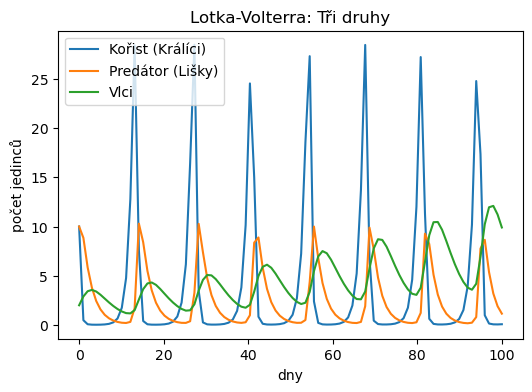

In [30]:
# Rozšířený model se třetím druhem (vlci)
def run_lv3(params, y0, days=100):
    a, b, c, d, e, f, g, h = params
    def lv3(t, y):
        x, y1, z = y
        dx = a*x - b*x*y1 - e*x*z           # králičí růst - lov lyšek - lov vlků
        dy = -c*y1 + d*x*y1 - g*y1*z        # smrt lyšek + přírůst z králíků - lov vlků
        dz = -f*z + e*x*z + h*y1*z          # smrt vlků + přírůst z králíků + přírůst z lyšek
        return [dx, dy, dz]
    sol = solve_ivp(lv3, [0, days], y0, dense_output=True)
    t = np.linspace(0, days, days)
    return t, sol.sol(t)
t, (X, Y, Z) = run_lv3((1.1, 0.4, 0.4, 0.1, 0.02, 0.2, 0.01, 0.05), (10, 10, 2)) # data doplňena o vlky - jí i lyšky i králíky
# Parametery:           (a,   b,   c,   d,   e,   f,  g,   h)

plt.figure(figsize=(6,4))
plt.plot(t, X, label='Kořist (Králíci)')
plt.plot(t, Y, label='Predátor (Lišky)')
plt.plot(t, Z, label='Vlci')
plt.legend()
plt.xlabel('dny')
plt.ylabel('počet jedinců')
plt.title('Lotka-Volterra: Tři druhy')
plt.show()

# Úloha 3: Abstraktní umění - Monte Carlo
# Monte Carlo metoda v Abstract Art Generátoru

Funkce `abstract_art_generator` využívá Monte Carlo metodu prostřednictvím tzv. "náhodné procházky" (random walk).
```python
dx = np.random.randint(-1, 2)  # Náhodný krok v rozmezí -1, 0, nebo 1
dy = np.random.randint(-1, 2)  # Náhodný krok v rozmezí -1, 0, nebo 1
```
- Každý krok je nezávislý na předchozích
- Směr pohybu je zcela náhodný
- 5 nezávislých "štětců" (outer loop)
- Každý štětec dělá 1000 náhodných kroků (inner loop)


In [31]:
def abstract_art_generator(blobs = 5, canvas_size = 100):
    canvas = np.zeros((canvas_size, canvas_size, 3))
    
    # generace několika náhodných barevných skvrn
    for _ in range(blobs):
        x, y = canvas_size//2, canvas_size//2
        color = np.random.random(3)
        
        for _ in range(1000):
            # náhodný krok v mřížce
            dx = np.random.randint(-1, 2)
            dy = np.random.randint(-1, 2)
            
            # Zajištění, že se pohybujeme uvnitř plátna
            x = max(0, min(canvas_size-1, x + dx))
            y = max(0, min(canvas_size-1, y + dy))
            
            # přidání barvy s náhodným šumem
            canvas[x, y] = color + np.random.normal(0, 0.1, 3)
            canvas[x, y] = np.clip(canvas[x, y], 0, 1)
    
    return canvas

Text(0.5, 1.0, 'Generované abstraktní umění')

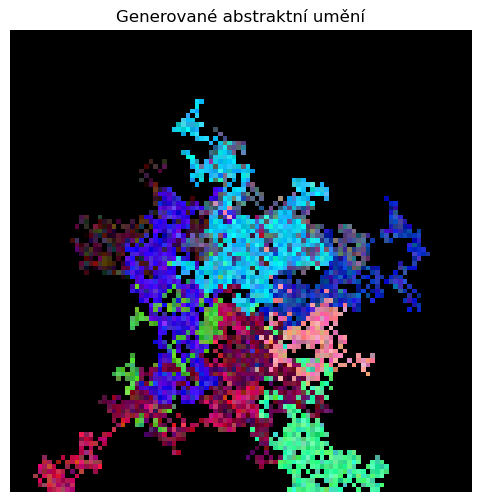

In [32]:
abstract_art = abstract_art_generator(10)
plt.figure(figsize=(6, 6))
plt.imshow(abstract_art)
plt.axis('off')
plt.title('Generované abstraktní umění')

## Úloha 3: Alternativní model Zombie Apokalypsy
Implementace ODE modelu pro lidi (S), zombíky (Z) a odstraněné (R).


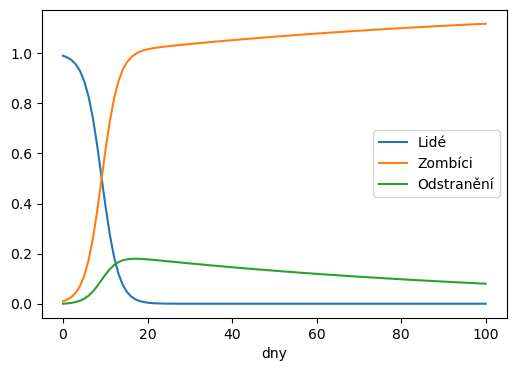

In [33]:
def run_zombie(alpha, beta, delta, S0=0.99, Z0=0.01, R0_init=0, days=100):
    # Compartments:
    #   S = zdraví lidé
    #   Z = zombíci
    #   R = odstranění (mrtví nebo zlikvidovaní zombíci)
    # Parametry:
    #   beta: míra přenosu nakažení
    #   alpha: reanimace z R do Z
    #   delta: likvidace zombíků (Z → R)
    def zombies(t, y):
        S, Z, R = y
        dS = -beta * S * Z               # zdraví lidé nakaženi zombíky
        dZ = beta * S * Z + alpha * R    # noví zombíci + reanimace
        dR = delta * S * Z - alpha * R   # mrtví (likvidace) minus reanimace
        return [dS, dZ, dR]

    sol = solve_ivp(zombies, [0, days], [S0, Z0, R0_init], dense_output=True)
    t = np.linspace(0, days, days)
    return t, sol.sol(t)
t, (S, Z, R) = run_zombie(alpha=0.01, beta=0.5, delta=0.1)
plt.figure(figsize=(6,4))
plt.plot(t, S, label='Lidé')
plt.plot(t, Z, label='Zombíci')
plt.plot(t, R, label='Odstranění')
plt.legend(); plt.xlabel('dny'); plt.show()

In [34]:
%matplotlib widget
# Vytvoříme figure a axes pro interaktivní plot
fig, ax = plt.subplots(figsize=(8,5))

def update(R0):
    ax.clear()  # Vyčistíme axes
    
    # Spustíme simulaci a vykreslíme
    t, S, I, R = run_sir(R0, gamma)
    ax.plot(t, S, label='S - vnímaví')
    ax.plot(t, I, label='I - nakažení')
    ax.plot(t, R, label='R - uzdravení')
    
    # Nastavíme popisky
    ax.set_title(f'SIR model (R₀={R0:.1f})')
    ax.set_xlabel('dny')
    ax.set_ylabel('frakce populace')
    ax.set_ylim(0, 1)
    ax.grid(True)
    ax.legend()
    
    fig.canvas.draw_idle()

# Vytvoříme slider
R0_slider = widgets.FloatSlider(
    value=2.8,
    min=0.1,
    max=15.0,
    step=0.1,
    description='R₀:',
    continuous_update=False
)

# Propojíme slider s update funkcí
widgets.interactive(update, R0=R0_slider)

ModuleNotFoundError: No module named 'ipympl'